<a href="https://colab.research.google.com/github/cyankaet/orderml/blob/master/orderparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/orderml

/content/drive/.shortcut-targets-by-id/1FKl2J9VPA88stIpA_grTLED-Fv9_B7CF/orderml


Any other drive folder is, hint, probably not the correct one! Navigate to where your orderml folder is in your drive. This code should work for a top-level folder.

Check you're in the right folder.



In [ ]:
ls

chisurface.png  orderparams.ipynb          problems.txt  test.png
logs/           OrderPresentation.gslides  __pycache__/


Install non-default packages here.

In [ ]:
!pip install bumps
!pip install gym
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

     |████████████████████████████████| 522kB 2.7MB/s 
  Created wheel for bumps: filename=bumps-0.7.16-cp36-none-any.whl size=546174 sha256=22eb2cf2d823c8e8a90ab64545054c9ced3a069c4e0b913238983df5713e438d
  Stored in directory: /root/.cache/pip/wheels/41/f7/17/a898c85754ad1c6d7de087e28809af7989b81f14f200547de3
Successfully built bumps
TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 2.8MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


"Compile" code.

In [ ]:
class OrderMethods():

    def getData(T, p):
        Jt, Nf, Bk = p
        return OrderMethods.orderparameter(T, 160, Jt, Nf, Bk)

    def bsol(temp,p):
        Tn,Jt,Nf,Bk=p
        t=4.0*(Jt/(Jt+1.0))*Tn/temp
        #print t
        if (Tn<=0) or (Jt<=0) or temp>=Tn:
            xout=0.0
        else:
            xout=optimize.brentq(OrderMethods.bfun,0.0,t,args=(temp,p),xtol=1e-6)

        return xout


    def bfun(x,T,p):
        Tn,Jt,Nf,Bk=p
        if x==0.0:
            B=-1.0 # so that it wont find solution at zero
        else:
            B=(x-3*OrderMethods.brill(Jt,x)*(Jt/(Jt+1))*(Tn/T))
        return B

    def brill(j,x):
        temp=(2*j+1.0)/2/j
        if x==0:
            Br=0.0
        else:
            Br=temp/np.tanh(temp*x)-1.0/np.tanh(x/2/j)/2/j
        return Br

    def Intensity(T,p):
        Tn,Jt,Nf,Bk=p
        br=OrderMethods.brill(Jt,OrderMethods.bsol(T,p))
        bout=Bk+Nf*br**2
        return bout

    def orderparameter(T, Tn, Jt, Nf, Bk):
        p=[Tn, Jt, Nf, Bk]
        I=[]
        for t in T:
            I.append(OrderMethods.Intensity(t,p))
        return np.array(I)

    def fit(model):
        nllfs = []
        zin = []
        for tns in np.arange(50,200, 5):
            #print("zs", zs)
            model.Tn.value = tns
            model.update()
            schi=model.nllf()
            nllfs.append(schi)
            zin.append(tns)
        plt.scatter(zin, nllfs)
        plt.xlabel("tn in")
        plt.ylabel("chi") 
        plt.show()
        plt.savefig("chisurface")
        plt.close()
        problem = FitProblem(model)
        result = fitters.fit(problem, method='lm')
        for p, v in zip(problem._parameters, result.dx):
            p.dx = v
        return result.x, result.dx, problem.chisq(), problem._parameters
        

Execute main class.

In [ ]:
import sys
import numpy as np
import pylab as plt
import scipy.optimize as optimize
from bumps.names import *
import bumps.fitters as fitters
import gym.spaces as spaces
import gym

class OrderEnv(gym.Env): #add gym.env

    def __init__(self):
        self.reward_scale = 100
        self.episodeNum = 0
        self.steps = 0
        self.T = np.array([])
        self.startTn = 150
        self.p = [.885,330,.3]
        self.error = []

        # self.observation_space = spaces.Box(low = np.array([3]), high = np.array([340]))
        # self.action_space = spaces.Box(low = np.array([3]), high = np.array([340]))
        # self.action_space = spaces.Discrete(4)
        self.curTemp = 3
        self.x = self.startTn

        #logging arrays and vars
        self.rewards = [] #interepisodic
        self.chisqds = []
        self.transTemps = []
        self.totReward = 0 
        self.info = {}     

    def step(self, action): 
        # if (action == 0):
        #     action = 1
        # if (action == 1):
        #     action = 5
        # elif (action == 2):
        #     action = 10
        # elif (action == 3):
        #     action = 20

        print("stepping: ", self.episodeNum)
        print("ACTION            : ", action)

        self.curTemp += action
        #self.curTemp = action
        self.curTemp = self.round_to(self.curTemp, 0.5)
        print("curtemp: ", self.curTemp)

        self.steps += 1
        reward = -self.reward_scale
        self.T = np.append(self.T, self.curTemp)
        print("Temperature: ", self.T)
        
        if self.steps > 1:
            self.I = OrderMethods.getData(self.T, self.p)
            print("Intensity: ", self.I)
            self.error= np.sqrt(self.I)
            M = Curve(OrderMethods.orderparameter, self.T, self.I, self.error, Jt = self.p[0], Nf = self.p[1], Bk = self.p[2])
            M.Tn.range(10, 400)

            self.x, dx, chisq, params = OrderMethods.fit(M)
            self.x = self.x[0]
            print("THE RESULT:", self.x)

            dx = params[0].dx

            print("chisqds: ", chisq)
            print("BUT ARE WE SURE?:", dx)

            plt.plot(self.T, self.I, 'ro')
            plt.show()
            plt.close()

            # if(action > 0.5):
            #   reward += 1000

            if chisq < 2 and dx < 2:
                  reward += 100 + 1/dx

            self.chisqds.append(chisq)
            self.transTemps.append(self.x)

        print("highHIIIIGHHHHHH: ", (340-self.curTemp))
        print("rewaRD:: ", reward)

        self.totReward += reward
        np.append(self.state, self.curTemp)
        delta = abs(340 - self.curTemp)

        if (self.steps > 20 and chisq < 0.05 and dx < 2): #less than or equal to?
            print("terminated: excellent conditions")
            terminal = True
            self.log()

        elif (self.curTemp >= 340):
            print("terminated: oveer max temp")
            terminal = True
            self.log()
        elif (self.steps > 100):
            print("terminated: too long")
            terminal = True
            self.log()
        else:
            terminal = False

        return self.state, reward, terminal, self.info


    def reset(self):
        print("reset")
        self.steps = 0
        self.T = np.array([])
        self.I = []
        self.chisqds = []
        self.transTemps = []
        self.totReward = 0
        self.curTemp = 3
        self.state = np.array([self.curTemp])

        return self.state #starting state

    def log(self):
        self.episodeNum += 1

        filename = "logs/chis/chiLog-" + str(self.episodeNum) + ".txt"
        np.savetxt(filename, self.chisqds)

        filename = "logs/temps/tnLog-" + str(self.episodeNum) + ".txt"
        np.savetxt(filename, self.transTemps)

        self.rewards.append(self.totReward)
        filename = "logs/runrewards.txt"
        np.savetxt(filename, self.rewards)

    @property
    def action_space(self):
        return spaces.Box(low = np.array([0.5]), high = np.array([340 - self.curTemp]))
        # return spaces.Box(low = np.array([self.curTemp + 0.5]), high = np.array([340]))

    @property 
    def observation_space(self):
        return spaces.Box(low=3.0, high=340.0, shape=(self.steps + 1,), dtype=np.float32)


    def round_to(self, n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision


In [ ]:
from stable_baselines.common.env_checker import check_env
env = OrderEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)
a = env.action_space
o = env.observation_space
print(a)                    #prints Box(1,)
print(a.shape)              #prints (1,), note that you can do a.shape[0] which is 1 here
print(a.is_bounded())       #prints True if your action space is bounded
print(a.high)               #prints [1.] an array with the maximum value for each dim
print(a.low)                #prints [-1.] same for minimum value
print(o)
print(o.shape)

In [ ]:
from stable_baselines import DQN, PPO2, A2C, ACKTR
from stable_baselines.common.cmd_util import make_vec_env

# Instantiate the env
env = OrderEnv()
# wrap it
env = make_vec_env(lambda: env, n_envs=1) #retrieve?

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))



reset
stepping:  0
ACTION            :  [0.90911335]
curtemp:  4.0
Temperature:  [4.]
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  0
ACTION            :  [1.4491557]
curtemp:  5.5
Temperature:  [4.  5.5]
Intensity:  [330.3 330.3]


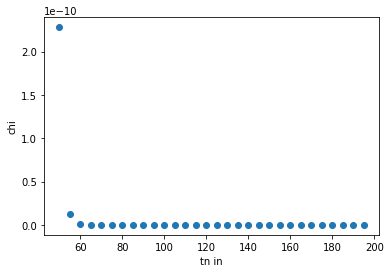

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


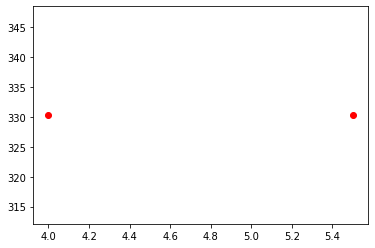

highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  6.0
Temperature:  [4.  5.5 6. ]
Intensity:  [330.3 330.3 330.3]


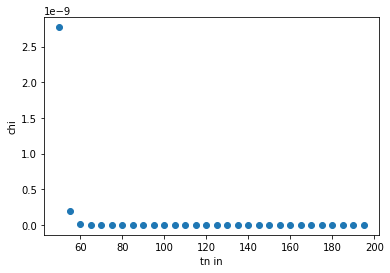

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


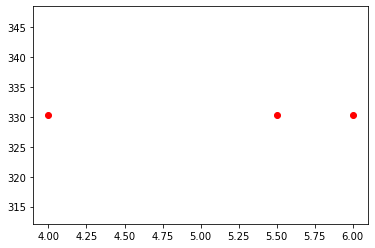

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  6.5
Temperature:  [4.  5.5 6.  6.5]
Intensity:  [330.3 330.3 330.3 330.3]


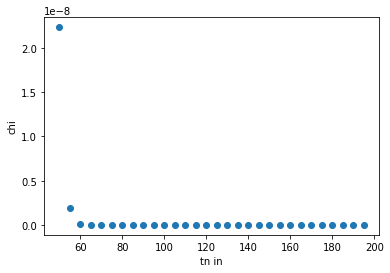

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


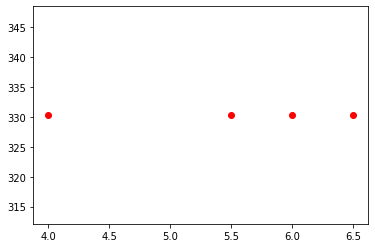

highHIIIIGHHHHHH:  333.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.8432172]
curtemp:  7.5
Temperature:  [4.  5.5 6.  6.5 7.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3]


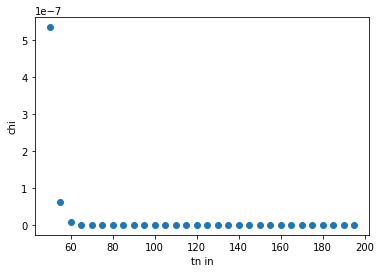

THE RESULT: 195.0
chisqds:  1.2937414378280443e-27
BUT ARE WE SURE?: 99999999.99999999


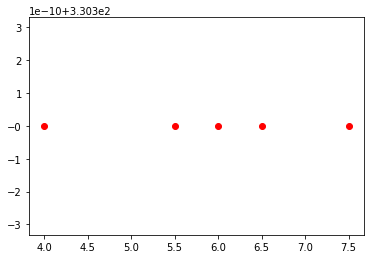

highHIIIIGHHHHHH:  332.5
rewaRD::  -100
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 3         |
| nupdates           | 1         |
| policy_entropy     | 1.42      |
| total_timesteps    | 5         |
| value_loss         | 1.07e+05  |
----------------------------------
stepping:  0
ACTION            :  [0.5]
curtemp:  8.0
Temperature:  [4.  5.5 6.  6.5 7.5 8. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3]


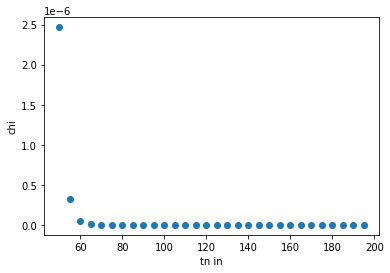

THE RESULT: 195.0
chisqds:  7.619623485249855e-26
BUT ARE WE SURE?: 99999999.99999999


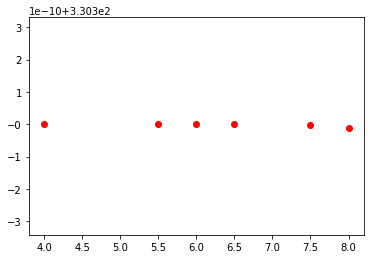

highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  8.5
Temperature:  [4.  5.5 6.  6.5 7.5 8.  8.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3]


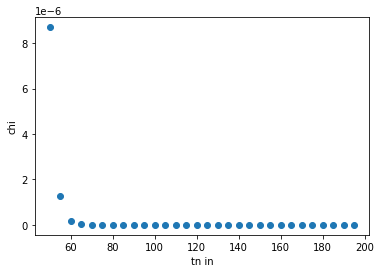

THE RESULT: 170.0985000000031
chisqds:  1.970686957703008e-24
BUT ARE WE SURE?: 99999999.99999999


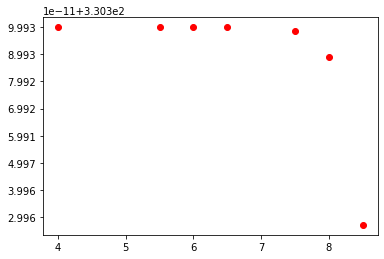

highHIIIIGHHHHHH:  331.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  9.0
Temperature:  [4.  5.5 6.  6.5 7.5 8.  8.5 9. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


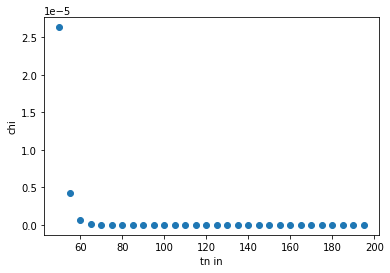

THE RESULT: 160.00017393674878
chisqds:  0.0
BUT ARE WE SURE?: 282460438496.25006


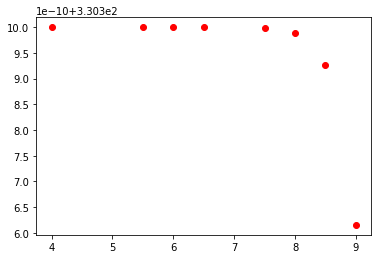

highHIIIIGHHHHHH:  331.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  9.5
Temperature:  [4.  5.5 6.  6.5 7.5 8.  8.5 9.  9.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


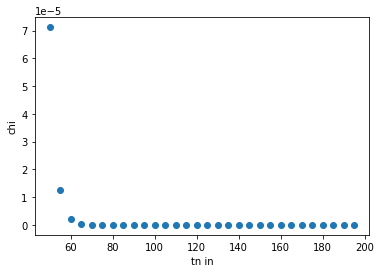

THE RESULT: 159.999954064838
chisqds:  0.0
BUT ARE WE SURE?: 63116705667.98084


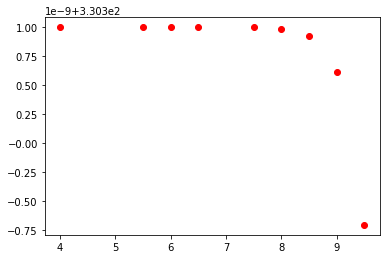

highHIIIIGHHHHHH:  330.5
rewaRD::  -100
stepping:  0
ACTION            :  [1.0479765]
curtemp:  10.5
Temperature:  [ 4.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999998]


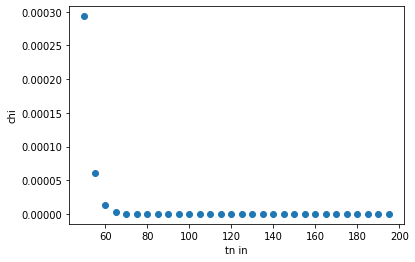

THE RESULT: 159.9999969517987
chisqds:  0.0
BUT ARE WE SURE?: 5462354894.890634


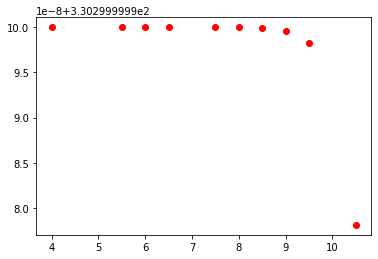

highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  11.0
Temperature:  [ 4.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999998
 330.29999993]


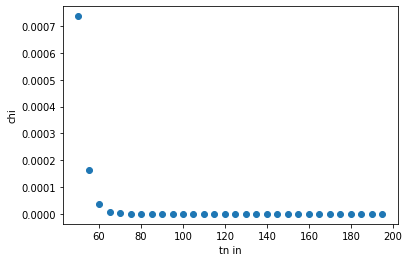

THE RESULT: 159.9999979027271
chisqds:  0.0
BUT ARE WE SURE?: 1800147528.0805118


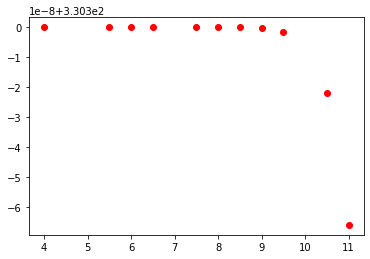

highHIIIIGHHHHHH:  329.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  11.5
Temperature:  [ 4.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11.  11.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999998
 330.29999993 330.29999982]


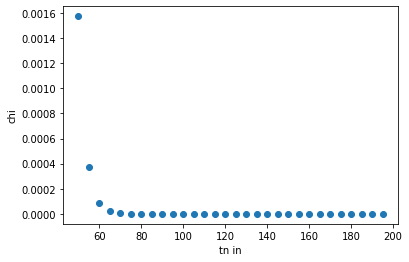

THE RESULT: 159.99999930048617
chisqds:  0.0
BUT ARE WE SURE?: 675633491.9561619


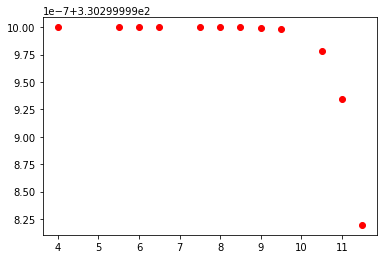

highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  0
ACTION            :  [2.6649187]
curtemp:  14.0
Temperature:  [ 4.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11.  11.5 14. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999998
 330.29999993 330.29999982 330.2999906 ]


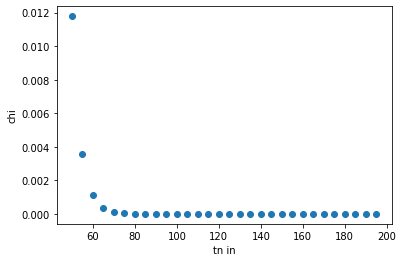

THE RESULT: 159.99999999969006
chisqds:  0.0
BUT ARE WE SURE?: 17009246.79947631


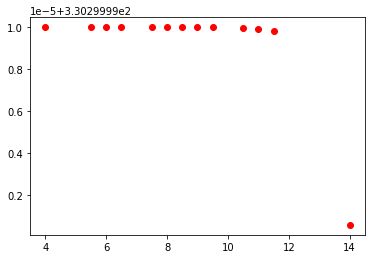

highHIIIIGHHHHHH:  326.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  14.5
Temperature:  [ 4.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11.  11.5 14.  14.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999998
 330.29999993 330.29999982 330.2999906  330.29998239]


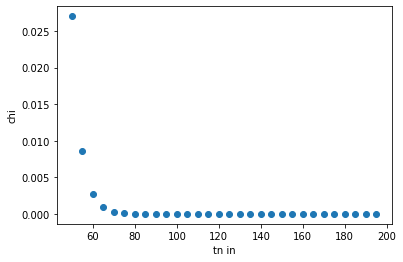

THE RESULT: 160.0000000173124
chisqds:  0.0
BUT ARE WE SURE?: 8234965.27419349


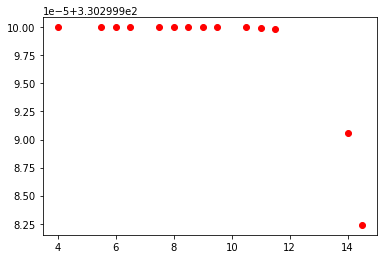

highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  15.0
Temperature:  [ 4.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11.  11.5 14.  14.5
 15. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999998
 330.29999993 330.29999982 330.2999906  330.29998239 330.29996838]


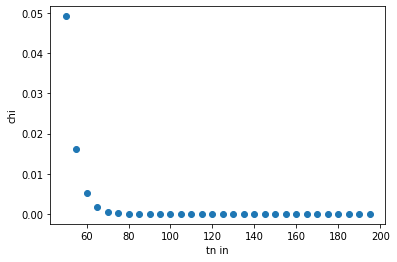

THE RESULT: 159.9999999835116
chisqds:  6.987531767755815e-31
BUT ARE WE SURE?: 4528426.932840962


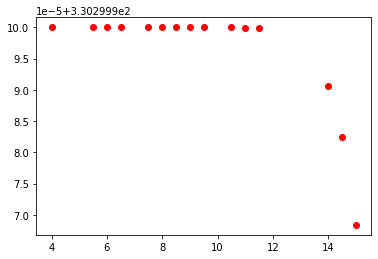

highHIIIIGHHHHHH:  325.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  15.5
Temperature:  [ 4.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11.  11.5 14.  14.5
 15.  15.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999998
 330.29999993 330.29999982 330.2999906  330.29998239 330.29996838
 330.29994532]


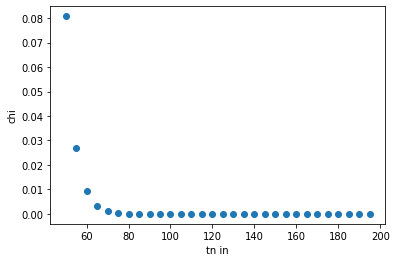

THE RESULT: 159.99999999009717
chisqds:  6.521696316572094e-31
BUT ARE WE SURE?: 2634995.559057927


KeyboardInterrupt: ignored

In [ ]:
# Train the agent
model = A2C('MlpPolicy', env, verbose=1).learn(5000)

In [ ]:
# Test the trained agent
obs = env.reset()
n_steps = 20
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render(mode='console')
  if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print("Goal reached!", "reward=", reward)
    break

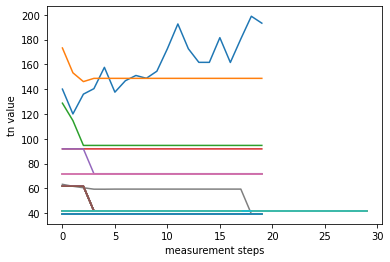

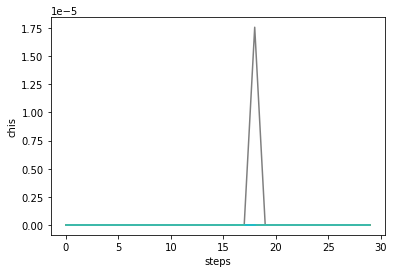

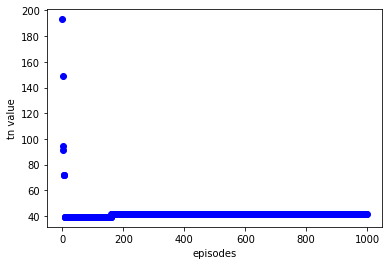

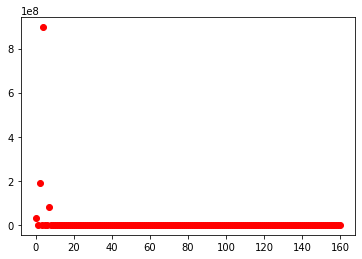

In [ ]:
numTrials = 1000

endParams = [[] for i in range(numTrials)]
data = [[] for i in range(numTrials)]
chis = [[] for i in range(numTrials)]
endtns = []
imagestore = "logs/"
logstore = "logs/"

for i in range(1,numTrials+1):
    data[i-1] = np.loadtxt(logstore +  "temps/tnLog-" + str(i) + ".txt")
    #print(data[i-1])
    chis[i-1] = np.loadtxt(logstore + "chis/chiLog-" + str(i) + ".txt")

for i in range (0, len(data)): 
    plt.plot(data[i], label = str(i))
    endtns.append(data[i][-1])

plt.xlabel("measurement steps")
plt.ylabel("tn value")
plt.show()
plt.savefig(imagestore + "tns.png")
plt.close()

for i in range (0, len(chis)):
  plt.plot(chis[i], label = str(i))

plt.xlabel("steps")
plt.ylabel("chis")
plt.show()
plt.close()

plt.plot(endtns, 'bo')
plt.xlabel("episodes")
plt.ylabel("tn value")
plt.show()
plt.savefig(imagestore + "endtns.png")
plt.close()

rewards = np.loadtxt('logs/runrewards.txt')
plt.plot(rewards, 'ro')
plt.show()
plt.close()


temperature:  [  8  13  18  23  43  48  53  58  63  68  88 108 113 118 138 158 178 198
 208 228 248]
Intensity:  [3.30300000e+02 3.30299998e+02 3.30299465e+02 3.30288400e+02
 3.28262096e+02 3.26472537e+02 3.23876588e+02 3.20375706e+02
 3.15896520e+02 3.10384826e+02 2.77335541e+02 2.25744439e+02
 2.09855653e+02 1.92752737e+02 1.12062994e+02 1.14655906e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]


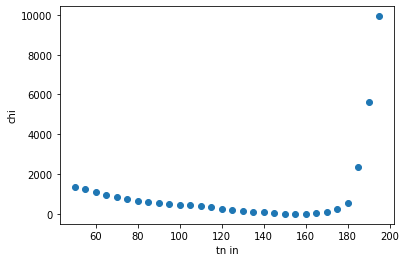

[160.]


In [ ]:
p=[.885,330,.3]
#T=np.arange(3, 300, 4)
T = np.array([ 8, 13,  18,  23,  43,  48,  53,  58,  63,  68,  88, 108, 113, 118, 138, 158,  178, 198, 208, 228, 248])
print("temperature: ", T)
#T=N.arange(10,300,2)
I=[]
error = []

I=OrderMethods.orderparameter(T, 160,p[0],p[1],p[2])
print("Intensity: ", I)
error= np.sqrt(I)
#print(error)

M = Curve(OrderMethods.orderparameter, T, I, error, Jt = p[0], Nf = p[1], Bk = p[2])
M.Tn.range(10,400)

x, dx, chisq, params = OrderMethods.fit(M)
print(x)

fitI = OrderMethods.orderparameter(T, x, p[0],p[1],p[2])

plt.errorbar(T, I, error)
plt.plot(T, fitI,'ro', markersize = 2)
plt.xlabel("Temperature")
plt.ylabel("Intensity") 
plt.savefig("test")
plt.close()